In [1]:
import pandas as pd
import numpy as np

import tubesml as tml

from source.validate import random_split, yearly_split
from source.report import report_points, report_victory, yearly_wrapper
from source.iterate import Iterator

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import xgboost as xgb

import optuna
from optuna import Trial

In [2]:
df = pd.read_csv('data/processed_men/training_data.csv')

df['seed_round1'] = 0
df['seed_round2'] = 0

df.loc[(df.T1_Seed < 5) & (df.stage_Round1 == 1), 'seed_round1'] = 1
df.loc[(df.T1_Seed < 2) & (df.stage_Round2 == 1), 'seed_round2'] = 1

df['off_edge_Seed'] = df['delta_Seed'] * df['delta_off_edge']
df['def_edge_Seed'] = df['delta_Seed'] * df['delta_def_edge']

df['T1_DR_edge'] = df['T1_DR_opportunity'] - df['T2_OR_opportunity']
df['T2_DR_edge'] = df['T2_DR_opportunity'] - df['T1_OR_opportunity']
df['delta_DR_edge'] = df['T1_DR_edge'] - df['T2_DR_edge']

df['T1_OR_edge'] = df['T1_OR_opportunity'] - df['T2_DR_opportunity']
df['T2_OR_edge'] = df['T2_OR_opportunity'] - df['T1_DR_opportunity']
df['delta_OR_edge'] = df['T1_OR_edge'] - df['T2_OR_edge']

df['T1_DR_rank'] = df['T1_DR'] * df['T1_Rank']
df['T2_DR_rank'] = df['T2_DR'] * df['T2_Rank']

kfolds = KFold(n_splits=7, shuffle=True, random_state=23)

# XGBoost

In [17]:
to_use = ['ID', 'target', 'Season', 'target_points']

d_car = []
t_car = ['Score', 'Ast', 'Blk', 'Away', 'DR', 'FGA', 'FGA3', 'FGM', 
        'off_rating', 'def_rating', 'Rank', 'DR_rank',
        'FGM3', 'OR', 'Stl', 'TO', 'FGM_perc', 'FGM3_perc', 'high_seed', 'low_seed']
l2wd_car = []
l2wt_car = []

for c in d_car:
    to_use += [f'delta_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in t_car:
    to_use += [f'T1_{c}', f'T2_{c}']
    
for c in l2wd_car:
    to_use += [f'delta_L2W_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in l2wt_car:
    to_use += [f'T1_L2W_{c}', f'T2_L2W_{c}']
    

#to_use += ['seed_round1', 'seed_round2', 'off_edge_Seed', 'def_edge_Seed'] 

In [35]:
scores

,mae_oof,mae_test,mse_oof,mse_test,acc_oof,acc_test,logloss_oof,logloss_test,unsure_oof,unsure_test,year
0,8.6949,7.6560,11.1634,10.0231,0.7163,0.7698,0.5339,0.5102,23.51,26.98,2015
1,8.5965,9.3599,11.0266,12.0979,0.7197,0.7143,0.5330,0.5439,23.21,21.43,2016
2,8.6976,8.0655,11.1578,10.7083,0.7153,0.7857,0.5347,0.4908,22.47,19.84,2017
3,8.6609,8.7138,11.0834,11.7789,0.7257,0.7143,0.5286,0.5601,22.32,19.05,2018
4,8.5671,9.5088,11.0534,11.7623,0.7188,0.7302,0.5325,0.4660,22.42,25.40,2019
5,8.6434,8.6608,11.0970,11.3012,0.7191,0.7429,0.5326,0.5142,22.79,22.54,total


In [98]:
to_use = ['ID', 'target', 'Season', 'target_points']

d_car = []
t_car = ['Score', 'Ast', 'Blk', 'Away', 'DR', 'FGA', 'FGA3', 'FGM', 
        'off_rating', 'def_rating', 'Rank', 'DR_rank',
        'FGM3', 'OR', 'Stl', 'TO', 'FGM_perc', 'FGM3_perc', 'high_seed', 'low_seed']
l2wd_car = []
l2wt_car = ['Score']

for c in d_car:
    to_use += [f'delta_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in t_car:
    to_use += [f'T1_{c}', f'T2_{c}']
    
for c in l2wd_car:
    to_use += [f'delta_L2W_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in l2wt_car:
    to_use += [f'T1_L2W_{c}', f'T2_L2W_{c}']

In [104]:
scores

,mae_oof,mae_test,mse_oof,mse_test,acc_oof,acc_test,logloss_oof,logloss_test,unsure_oof,unsure_test,year
0,8.7712,7.6162,11.2168,10.0130,0.7049,0.8016,0.5359,0.5114,23.51,26.98,2015
1,8.6026,9.3765,11.0634,12.1337,0.7153,0.7302,0.5340,0.5444,23.61,22.22,2016
2,8.6937,8.0109,11.1262,10.6417,0.7143,0.7937,0.5341,0.4851,21.43,19.84,2017
3,8.6312,8.6917,11.0704,11.7591,0.7183,0.7222,0.5285,0.5590,21.73,19.84,2018
4,8.5949,9.6050,11.0718,11.8381,0.7173,0.7143,0.5337,0.4699,22.77,23.81,2019
5,8.6587,8.6601,11.1099,11.3062,0.7140,0.7524,0.5333,0.5140,22.61,22.54,total


In [216]:
to_use = ['ID', 'target', 'Season', 'target_points']

d_car = []
t_car = ['Score', 'Ast', 'Blk', 'Away', 'DR', 'FGA', 'FGA3', 'FGM',
        'off_rating', 'def_rating', 'Rank', 'DR_rank',
        'FGM3', 'OR', 'Stl', 'TO', 'FGM_perc', 'FGM3_perc', 'high_seed', 'low_seed']
l2wd_car = []
l2wt_car = ['Score', 'FGM_perc']

for c in d_car:
    to_use += [f'delta_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in t_car:
    to_use += [f'T1_{c}', f'T2_{c}']
    
for c in l2wd_car:
    to_use += [f'delta_L2W_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in l2wt_car:
    to_use += [f'T1_L2W_{c}', f'T2_L2W_{c}']

In [220]:
scores

,mae_oof,mae_test,mse_oof,mse_test,acc_oof,acc_test,logloss_oof,logloss_test,unsure_oof,unsure_test,year
0,8.7483,7.5954,11.1711,9.9769,0.7073,0.7778,0.5341,0.5071,23.12,25.40,2015
1,8.5858,9.3082,11.0180,12.0504,0.7192,0.7302,0.5318,0.5387,22.97,19.05,2016
2,8.6643,8.0470,11.1012,10.5800,0.7138,0.7937,0.5350,0.4846,21.33,19.84,2017
3,8.5906,8.6862,11.0428,11.7552,0.7262,0.7063,0.5272,0.5579,22.87,16.67,2018
4,8.5502,9.5556,11.0114,11.7219,0.7123,0.7381,0.5321,0.4652,21.28,20.63,2019
5,8.6278,8.6385,11.0691,11.2452,0.7158,0.7492,0.5321,0.5109,22.31,20.32,total


In [3]:
to_use = ['ID', 'target', 'Season', 'target_points']

d_car = []
t_car = ['Score', 'Ast', 'Blk', 'Away', 'DR', 'FGA', 'FGA3', 'FGM',
        'off_rating', 'def_rating', 'Rank', 'DR_rank',
        'FGM3', 'OR', 'Stl', 'TO', 'FGM_perc', 'FGM3_perc', 'high_seed', 'low_seed']
l2wd_car = []
l2wt_car = ['Score', 'FGM_perc', 'TO_perposs']

for c in d_car:
    to_use += [f'delta_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in t_car:
    to_use += [f'T1_{c}', f'T2_{c}']
    
for c in l2wd_car:
    to_use += [f'delta_L2W_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in l2wt_car:
    to_use += [f'T1_L2W_{c}', f'T2_L2W_{c}']

In [340]:
scores

,mae_oof,mae_test,mse_oof,mse_test,acc_oof,acc_test,logloss_oof,logloss_test,unsure_oof,unsure_test,year
0,8.6859,7.5730,11.1531,9.9567,0.7207,0.7857,0.5336,0.5048,23.71,26.19,2015
1,8.5882,9.1211,11.0287,11.8612,0.7287,0.7302,0.5304,0.5361,22.62,18.25,2016
2,8.6580,8.0974,11.1327,10.6481,0.7188,0.7937,0.5331,0.4874,21.03,24.60,2017
3,8.6183,8.6763,11.0278,11.7680,0.7272,0.7143,0.5268,0.5530,22.87,18.25,2018
4,8.5551,9.5374,11.0158,11.6988,0.7237,0.7302,0.5300,0.4633,21.92,23.02,2019
5,8.6211,8.6010,11.0718,11.2121,0.7238,0.7508,0.5308,0.5089,22.43,22.06,total


In [4]:
def cauchyobj(labels, preds):
    c = 3000 
    x =  preds - labels    
    grad = x / (x**2 / c**2 + 1)
    hess = - c**2 *(x**2 - c**2) / (x**2 + c**2)**2
    return grad, hess

2015


MAE train: 			 8.6859
MAE test: 			 7.573
RMSE train: 			 11.1531
RMSE test: 			 9.9567
Accuracy train: 		 0.7207
Accuracy test: 			 0.7857
Logloss train: 			 0.5336
Logloss test: 			 0.5048
Unsure train: 			 23.71%
Unsure test: 			 26.19%


________________________________________


2016


MAE train: 			 8.5882
MAE test: 			 9.1211
RMSE train: 			 11.0287
RMSE test: 			 11.8612
Accuracy train: 		 0.7287
Accuracy test: 			 0.7302
Logloss train: 			 0.5304
Logloss test: 			 0.5361
Unsure train: 			 22.62%
Unsure test: 			 18.25%


________________________________________


2017


MAE train: 			 8.658
MAE test: 			 8.0974
RMSE train: 			 11.1327
RMSE test: 			 10.6481
Accuracy train: 		 0.7188
Accuracy test: 			 0.7937
Logloss train: 			 0.5331
Logloss test: 			 0.4874
Unsure train: 			 21.03%
Unsure test: 			 24.6%


________________________________________


2018


MAE train: 			 8.6183
MAE test: 			 8.6763
RMSE train: 			 11.0278
RMSE test: 			 11.768
Accuracy train: 		 0.7272


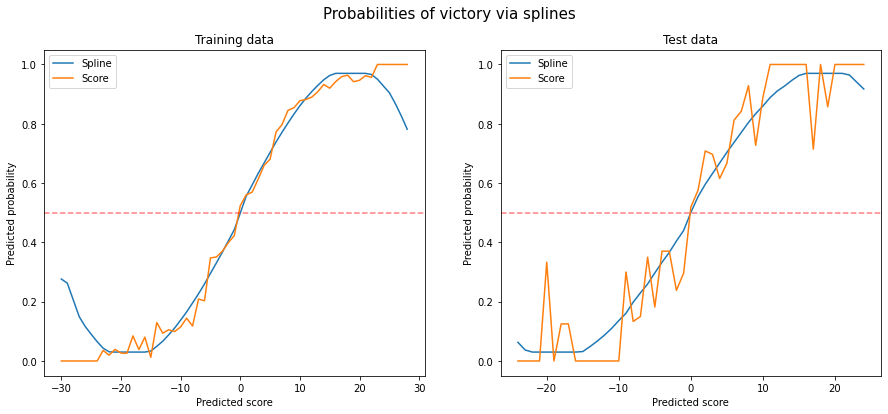

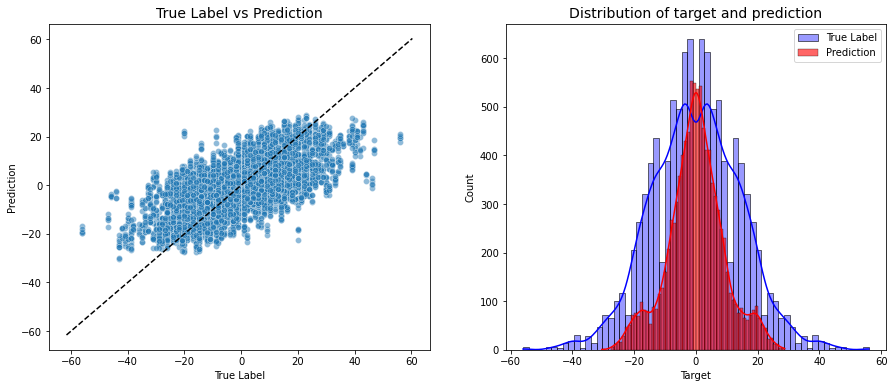

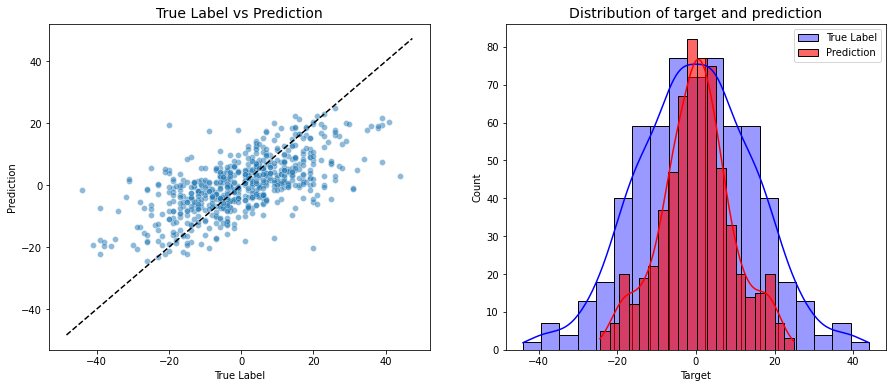

MAE train: 			 8.6211
MAE test: 			 8.601
RMSE train: 			 11.0718
RMSE test: 			 11.2121
Accuracy train: 		 0.7238
Accuracy test: 			 0.7508
Logloss train: 			 0.5308
Logloss test: 			 0.5089
Unsure train: 			 22.43%
Unsure test: 			 22.06%


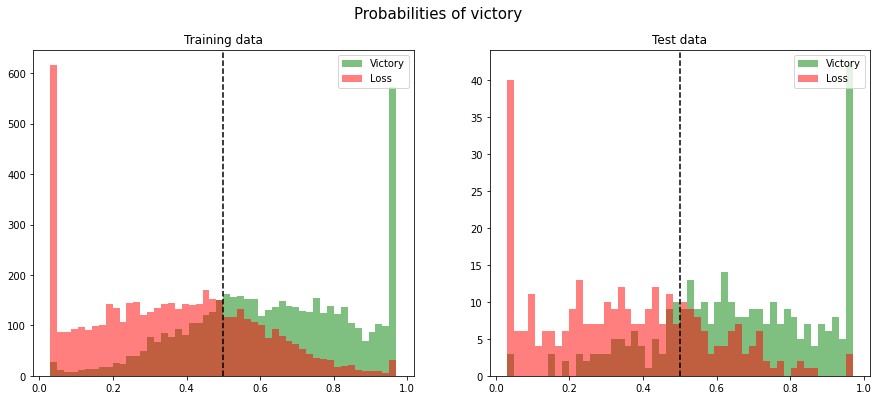

In [338]:
proc_pipe = Pipeline([('scl', tml.DfScaler(method='standard'))])
#proc_pipe = Pipeline([('imp', tml.DfImputer())])
estimator = xgb.XGBRegressor(learning_rate=0.05, n_estimators=1000, objective=cauchyobj, max_depth=3,
                                           n_jobs=5, subsample=0.35, reg_alpha=1, reg_lambda=10, colsample_bytree=0.7)
early_stopping = 100
eval_metric = 'mae'
pdp = None#[col for col in to_use if 'T1_' in col]

train_dict = {'trsf_pipe': proc_pipe, 'estimator': estimator, 
              'early_stopping': early_stopping, 'eval_metric': eval_metric, 'pdp': pdp, 'pdp_round': 1}


fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(data=df[to_use], 
                                                                                   model=None, 
                                                                                   kfolds=kfolds, 
                                                                                   target='target_points', 
                                                                                   boost=True, 
                                                                                   **train_dict)

scores = yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred, points=True)

In [339]:
for yr in imp_coef.keys():
    print(yr, imp_coef[yr]['n_iterations'])

2015 [124, 37, 98, 82, 267, 308, 294]
2016 [231, 184, 313, 61, 333, 291, 294]
2017 [93, 237, 186, 67, 281, 144, 259]
2018 [190, 252, 64, 72, 279, 104, 234]
2019 [413, 183, 62, 78, 350, 118, 269]


In [327]:
coefs  = imp_coef['2019']['feat_imp'].copy()

coefs.columns = ['mean_2019', 'std_2019']

for yr in ['2018', '2017', '2016', '2015']:
    tmp = imp_coef[yr]['feat_imp'].copy()
    tmp.columns = [f'mean_{yr}', f'std_{yr}']
    
    coefs = pd.merge(coefs, tmp, left_index=True, right_index=True)


coefs

,mean_2019,std_2019,mean_2018,std_2018,mean_2017,std_2017,mean_2016,std_2016,mean_2015,std_2015
feat,,,,,,,,,,
T2_DR_rank,0.087459,0.002346,0.091620,0.004358,0.097064,0.004209,0.093736,0.001651,0.088729,0.003309
T1_DR_rank,0.077689,0.003986,0.085754,0.005399,0.077276,0.006735,0.081750,0.005352,0.073105,0.002717
T1_Rank,0.073336,0.002687,0.069946,0.003786,0.068213,0.004071,0.072485,0.003771,0.076566,0.004923
T2_Rank,0.061428,0.004865,0.061640,0.005250,0.058777,0.005187,0.055995,0.003816,0.063646,0.005750
T2_high_seed,0.028120,0.003994,0.025254,0.005117,0.024396,0.004090,0.025612,0.003156,0.026436,0.003826
T1_high_seed,0.026849,0.001459,0.024343,0.002378,0.022089,0.001707,0.024948,0.000553,0.028175,0.003451
T1_low_seed,0.022306,0.002939,0.022845,0.001993,0.022341,0.002242,0.024044,0.002897,0.025052,0.002417
T1_off_rating,0.018404,0.000626,0.019263,0.000729,0.018182,0.000634,0.016946,0.000542,0.017441,0.000524
T2_low_seed,0.018219,0.000857,0.017893,0.000789,0.019733,0.001316,0.019789,0.001013,0.019258,0.000869


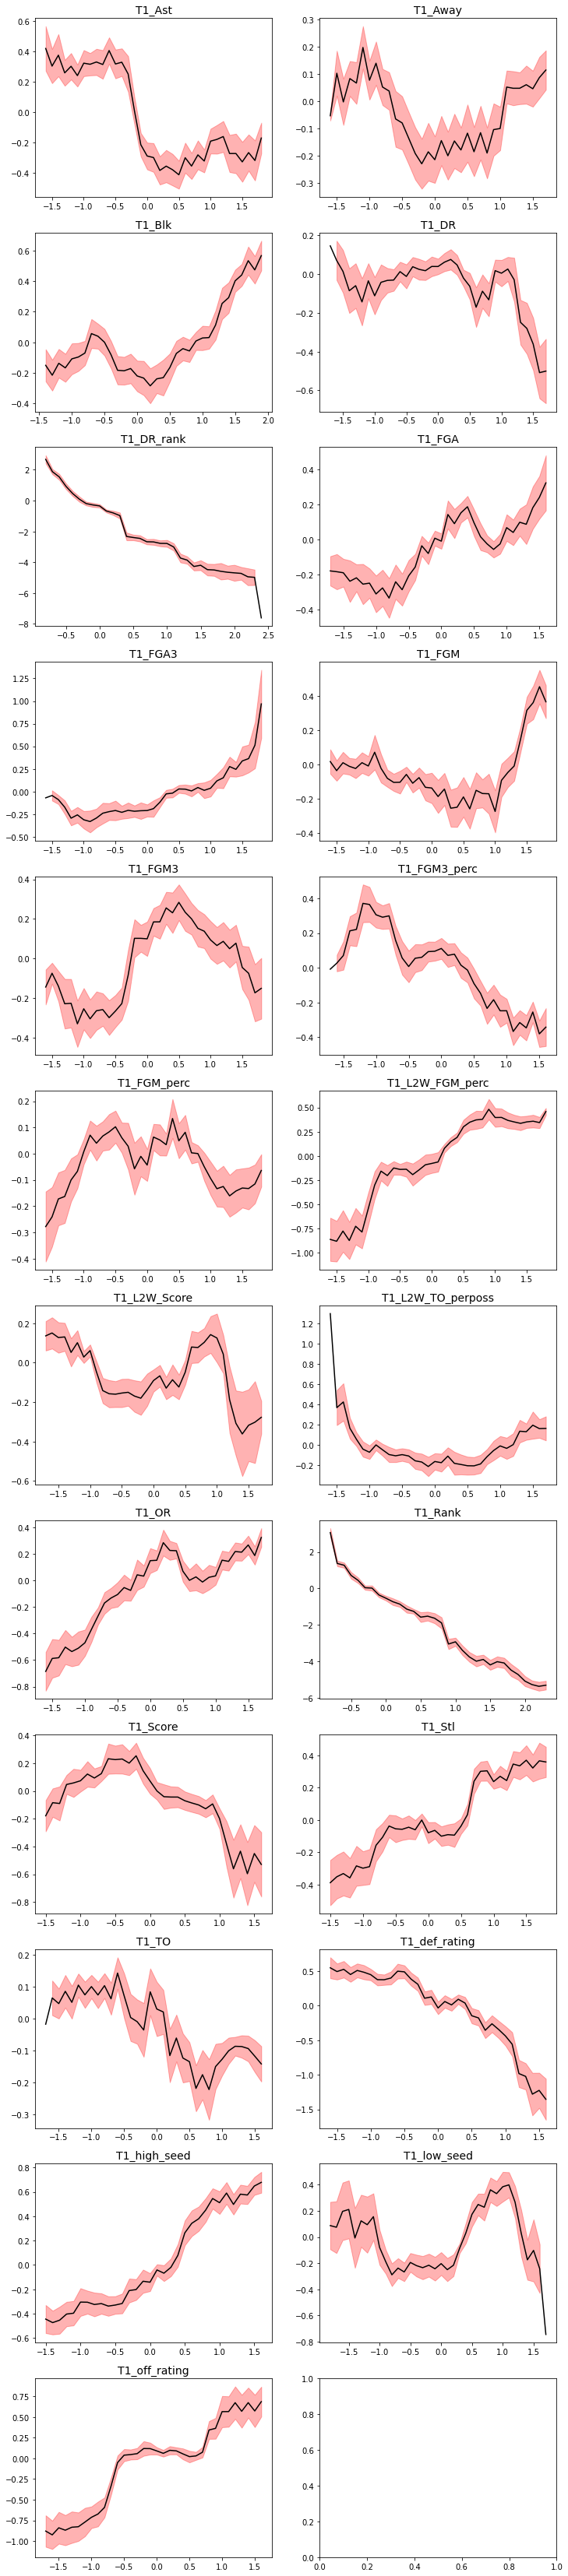

In [281]:
tml.plot_partial_dependence(imp_coef['2019']['pdp'], savename=None)

In [342]:
from source.report import _point_to_proba

In [350]:
for yr in test_pred.keys():
    tmp = test[yr].copy()
    tmp['true_label'] = y_test[yr]
    tmp['true_label'] = np.where(tmp['true_label'] > 0, 1, 0)
    _, tmp['oof_pred'] = _point_to_proba(oof_pred[yr], y_train[yr], test_pred[yr])
    tmp['Season'] = yr
    tmp.to_csv(f'oof/2021_men_xgboost_{yr}.csv', index=False)

In [352]:
tmp = train['2019'].copy()
tmp['true_label'] = y_train[yr]
tmp['true_label'] = np.where(tmp['true_label'] > 0, 1, 0)
tmp['oof_pred'], _ = _point_to_proba(oof_pred['2019'], y_train['2019'], test_pred['2019'])
tmp.to_csv(f'oof/2021_men_xgb_oof.csv',index=False)

In [283]:
train19 = train['2019'].reset_index(drop=True)
y_train19 = y_train['2019'].reset_index(drop=True)

In [5]:
def fit_xgb(trial, train, val, seed=None, num_rounds=5500):
    """Train XGBoost model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'logloss'
    params = {
        'objective': cauchyobj,
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': 0.05,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 10.0),
        "subsample": trial.suggest_uniform('subsample', 0.1, 1.0),
        "colsample_bytree": trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'n_estimators': num_rounds
    }

    params['seed'] = seed

    early_stop = 200
    verbose_eval = False

    model = xgb.XGBRegressor(**params)

    model.fit(X_train, y_train, early_stopping_rounds=early_stop, 
              eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae', verbose=verbose_eval)

    # predictions
    #y_pred_valid = model.predict_proba(X_valid)[:,1]
    y_pred_valid = model.predict(X_valid)
    
    mae = mean_absolute_error(y_valid, y_pred_valid)
    return model, y_pred_valid, mae

In [9]:
train19 = df[[col for col in to_use if col not in ['ID', 'target', 'Season', 'target_points']]]
y_train19 = df['target_points']

In [10]:
def objective(trial: Trial, fast_check=True, target_meter=0, return_info=False):
    folds = 7
    seed = 345
    shuffle = True
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    y_valid_pred_total = np.zeros(train19.shape[0])

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(train19, y_train19):
        train_data = train19.iloc[train_idx,:], y_train19.iloc[train_idx]
        valid_data = train19.iloc[valid_idx,:], y_train19.iloc[valid_idx]

        model, y_pred_valid, log = fit_xgb(trial, train_data, valid_data,
                                            num_rounds=2000)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        valid_score += log
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return valid_score, models, y_pred_valid, y_train
    else:
        return valid_score

In [11]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [12]:
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

In [13]:
study.best_trial.params

{'max_depth': 4,
 'reg_alpha': 7.384829812166711e-08,
 'reg_lambda': 5.322978448015755e-05,
 'gamma': 3.4222158328952134e-05,
 'subsample': 0.3517491608600791,
 'colsample_bytree': 0.6104872311199222}

2015


MAE train: 			 8.795
MAE test: 			 7.6532
RMSE train: 			 11.2813
RMSE test: 			 10.0922
Accuracy train: 		 0.7049
Accuracy test: 			 0.7857
Logloss train: 			 0.5389
Logloss test: 			 0.5172
Unsure train: 			 25.25%
Unsure test: 			 28.57%


________________________________________


2016


MAE train: 			 8.6915
MAE test: 			 9.3685
RMSE train: 			 11.1196
RMSE test: 			 11.9725
Accuracy train: 		 0.7098
Accuracy test: 			 0.7302
Logloss train: 			 0.5358
Logloss test: 			 0.5465
Unsure train: 			 21.97%
Unsure test: 			 23.81%


________________________________________


2017


MAE train: 			 8.722
MAE test: 			 8.1998
RMSE train: 			 11.194
RMSE test: 			 10.7741
Accuracy train: 		 0.7044
Accuracy test: 			 0.7857
Logloss train: 			 0.5393
Logloss test: 			 0.4955
Unsure train: 			 21.78%
Unsure test: 			 26.98%


________________________________________


2018


MAE train: 			 8.7039
MAE test: 			 8.8935
RMSE train: 			 11.0942
RMSE test: 			 11.939
Accuracy train: 		 0.7118

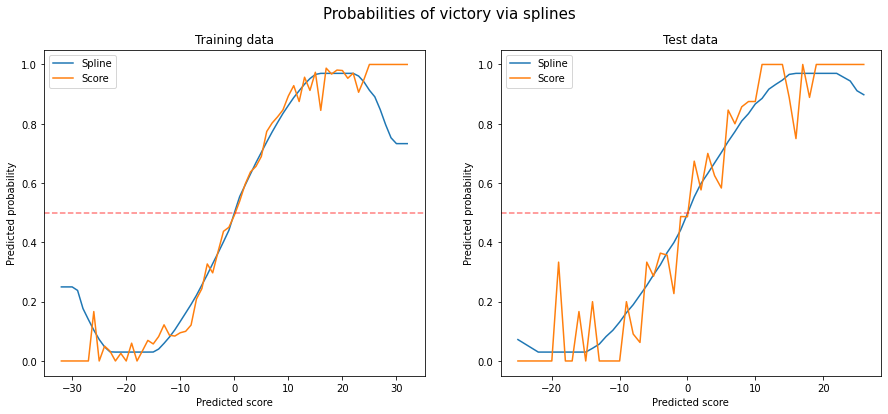

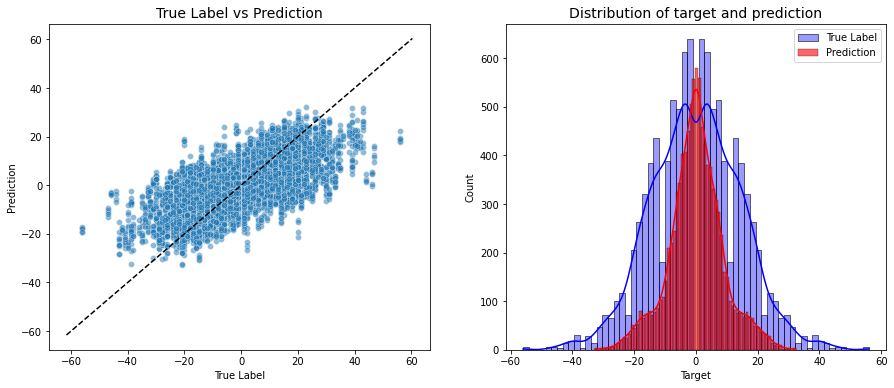

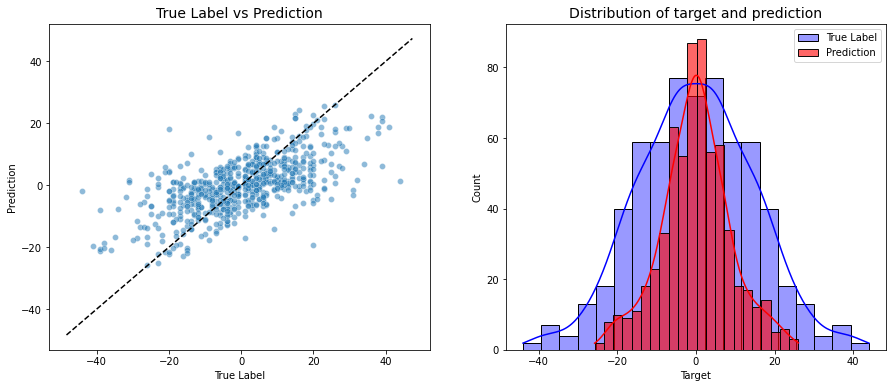

MAE train: 			 8.7023
MAE test: 			 8.7735
RMSE train: 			 11.1479
RMSE test: 			 11.377
Accuracy train: 		 0.7102
Accuracy test: 			 0.7429
Logloss train: 			 0.5377
Logloss test: 			 0.5213
Unsure train: 			 23.81%
Unsure test: 			 25.24%


,mae_oof,mae_test,mse_oof,mse_test,acc_oof,acc_test,logloss_oof,logloss_test,unsure_oof,unsure_test,year
0,8.7950,7.6532,11.2813,10.0922,0.7049,0.7857,0.5389,0.5172,25.25,28.57,2015
1,8.6915,9.3685,11.1196,11.9725,0.7098,0.7302,0.5358,0.5465,21.97,23.81,2016
2,8.7220,8.1998,11.1940,10.7741,0.7044,0.7857,0.5393,0.4955,21.78,26.98,2017
3,8.7039,8.8935,11.0942,11.9390,0.7118,0.7222,0.5344,0.5696,24.60,23.81,2018
4,8.5992,9.7526,11.0489,11.9735,0.7202,0.6905,0.5386,0.4721,25.45,23.02,2019
5,8.7023,8.7735,11.1479,11.3770,0.7102,0.7429,0.5377,0.5213,23.81,25.24,total


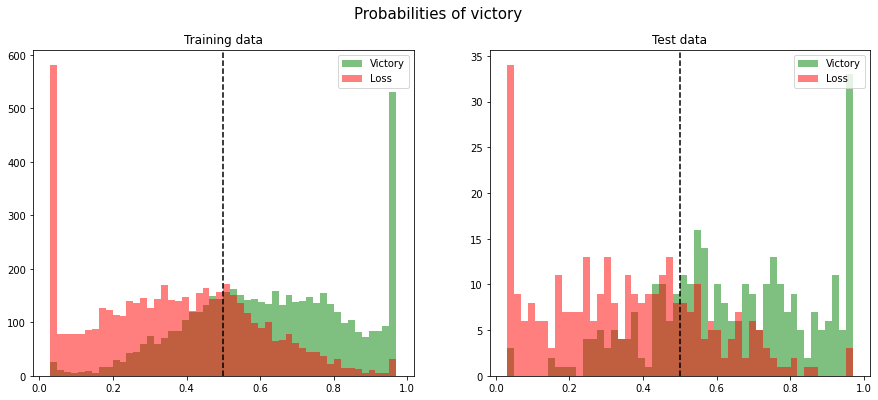

In [16]:
proc_pipe = Pipeline([('scl', tml.DfScaler(method='standard'))])
estimator = xgb.XGBRegressor(**study.best_trial.params, n_estimators=4000, learning_rate=0.05, random_state=24, n_jobs=-1)
early_stopping = 100
eval_metric = 'mae'
pdp = None#['T2_Rank', 'T1_Rank', 'T2_DR_rank', 'T1_DR_rank', 'T2_high_seed']

train_dict = {'trsf_pipe': proc_pipe, 'estimator': estimator, 
              'early_stopping': early_stopping, 'eval_metric': eval_metric, 'pdp': pdp, 'pdp_round': 1}


fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(data=df[to_use], 
                                                                                   model=None, 
                                                                                   kfolds=kfolds, 
                                                                                   target='target_points', 
                                                                                   boost=True, 
                                                                                   **train_dict)

yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred, points=True)

In [17]:
for yr in imp_coef.keys():
    print(yr, imp_coef[yr]['n_iterations'])

2015 [40, 26, 67, 46, 59, 137, 150]
2016 [156, 71, 67, 43, 147, 223, 104]
2017 [114, 306, 40, 45, 283, 180, 102]
2018 [91, 29, 68, 44, 64, 57, 71]
2019 [308, 33, 39, 62, 64, 38, 57]


In [18]:
coefs  = imp_coef['2019']['feat_imp'].copy()

coefs.columns = ['mean_2019', 'std_2019']

for yr in ['2018', '2017', '2016', '2015']:
    tmp = imp_coef[yr]['feat_imp'].copy()
    tmp.columns = [f'mean_{yr}', f'std_{yr}']
    
    coefs = pd.merge(coefs, tmp, left_index=True, right_index=True)


coefs

,mean_2019,std_2019,mean_2018,std_2018,mean_2017,std_2017,mean_2016,std_2016,mean_2015,std_2015
feat,,,,,,,,,,
T2_DR_rank,0.078148,0.003192,0.081914,0.005171,0.084275,0.004840,0.074051,0.003008,0.072112,0.003300
T1_DR_rank,0.075429,0.003604,0.081585,0.005290,0.079707,0.003871,0.079728,0.003029,0.084424,0.003740
T1_Rank,0.064453,0.003112,0.066044,0.002120,0.063580,0.001818,0.064522,0.002723,0.064567,0.002818
T2_Rank,0.062563,0.003006,0.063519,0.002317,0.060142,0.002932,0.067658,0.003944,0.065484,0.002395
T2_high_seed,0.034780,0.003637,0.032452,0.001975,0.030155,0.001613,0.032493,0.002169,0.033681,0.001790
T2_low_seed,0.023407,0.001199,0.026053,0.002001,0.026218,0.001897,0.026928,0.002683,0.025191,0.001645
T1_high_seed,0.022988,0.002029,0.019795,0.001334,0.018975,0.001896,0.020307,0.000760,0.019268,0.000921
T1_low_seed,0.022756,0.001246,0.022492,0.001278,0.024029,0.000996,0.023091,0.001391,0.023397,0.000787
T1_def_rating,0.020056,0.000763,0.019552,0.000528,0.019318,0.000753,0.019244,0.000659,0.019493,0.000663


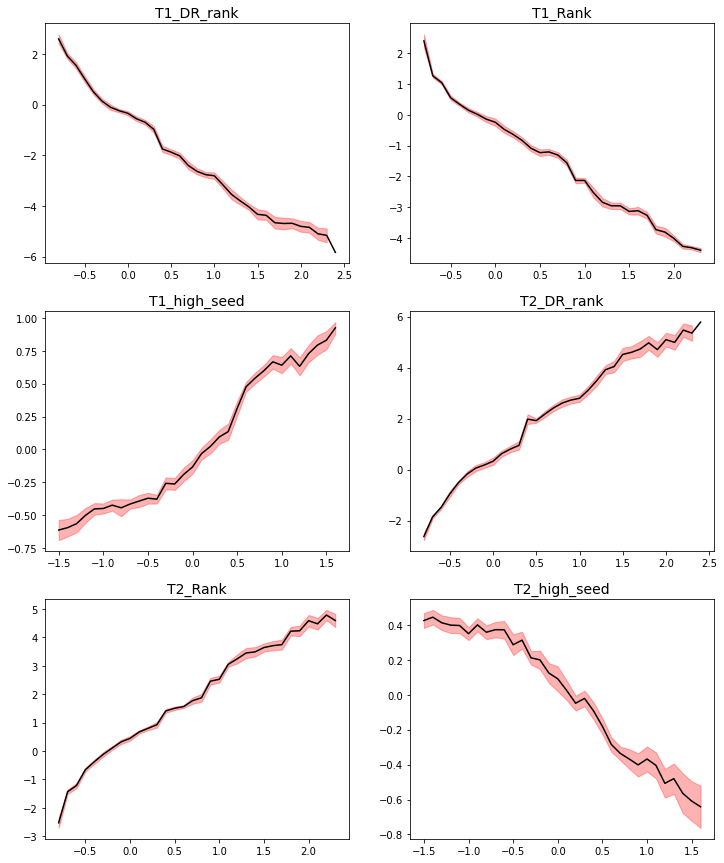

In [33]:
tml.plot_partial_dependence(imp_coef['2019']['pdp'], savename=None)

In [14]:
to_use = ['ID', 'target', 'Season', 'target_points']

car = ['Score', 'opp_score', 'True_shooting_perc', 
       'Stl', 'OR', 'off_rating', 'def_rating', 'TO', 'DR_edge'] 

for c in car:
    to_use += [f'delta_{c}'] # f'T1_{c}', f'T2_{c}', 

to_use += ['seed_round1', 'seed_round2', 'off_edge_Seed', 'def_edge_Seed'] 

In [43]:
pipe = Pipeline([('scl', tml.DfScaler()),
                 #('PCA', tml.DfPCA(n_components=0.7, compress=True, random_state=24)),
                 ('lgb', lgb.LGBMRegressor(learning_rate=0.1, n_estimators=600, objective=cauchyobj,
                                           n_jobs=5, subsample=0.7, reg_alpha=5, reg_lambda=1))])

grid_param = {'scl__method': ['standard', 'robust'], 
              'PCA__n_components': [0.5, 0.6, 0.7, 0.8, 0.9], 
              'lgb__num_leaves': [10, 40, 70, 100], 
              'lgb__reg_alpha': [0, 0.5, 1, 2, 5], 
              'lgb__reg_lambda': [0, 0.5, 1, 2, 5]}

fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(df[to_use], pipe, kfolds, 'target_points', tune=False, param_grid=grid_param)

2015


MAE train: 			 9.2914
MAE test: 			 7.7842
RMSE train: 			 11.7705
RMSE test: 			 10.1805
Accuracy train: 		 0.6984
Accuracy test: 			 0.7222
AUC ROC train: 			 0.6984
AUC ROC test: 			 0.7222
Logloss train: 			 0.553
Logloss test: 			 0.5025
Unsure train: 			 18.2%
Unsure test: 			 22.22%


________________________________________


2016


MAE train: 			 9.2709
MAE test: 			 9.8471
RMSE train: 			 11.7122
RMSE test: 			 12.3281
Accuracy train: 		 0.6969
Accuracy test: 			 0.7063
AUC ROC train: 			 0.6969
AUC ROC test: 			 0.7063
Logloss train: 			 0.5558
Logloss test: 			 0.5746
Unsure train: 			 19.69%
Unsure test: 			 14.29%


________________________________________


2017


MAE train: 			 9.2455
MAE test: 			 8.313
RMSE train: 			 11.7268
RMSE test: 			 11.0625
Accuracy train: 		 0.6944
Accuracy test: 			 0.7698
AUC ROC train: 			 0.6944
AUC ROC test: 			 0.7698
Logloss train: 			 0.5496
Logloss test: 			 0.4985
Unsure train: 			 18.4%
Unsure test: 			 15.87%


____________

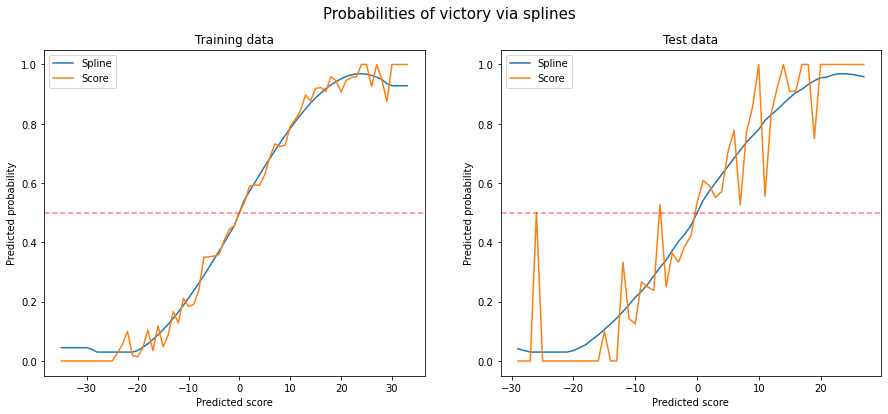

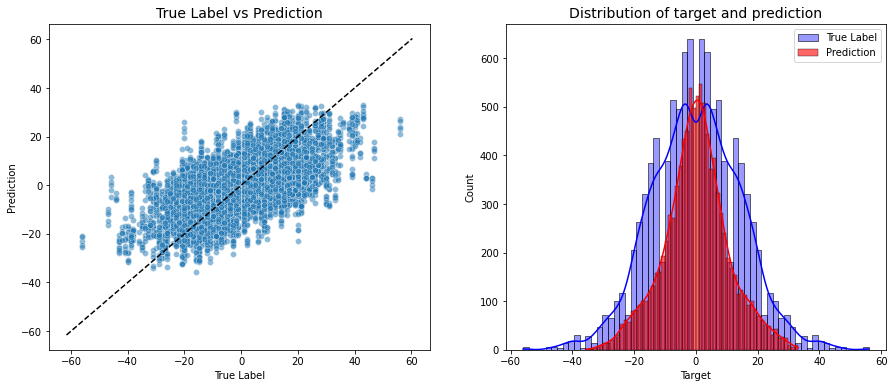

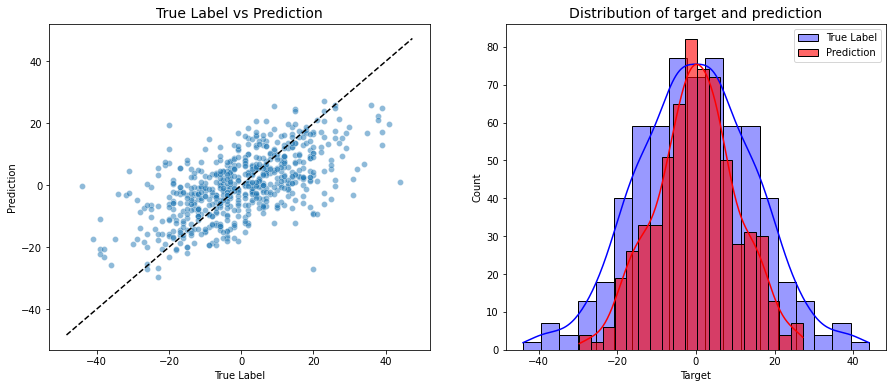

MAE train: 			 9.2317
MAE test: 			 9.0747
RMSE train: 			 11.691
RMSE test: 			 11.7364
Accuracy train: 		 0.6967
Accuracy test: 			 0.7302
AUC ROC train: 			 0.6967
AUC ROC test: 			 0.7302
Logloss train: 			 0.5529
Logloss test: 			 0.5295
Unsure train: 			 18.91%
Unsure test: 			 16.19%


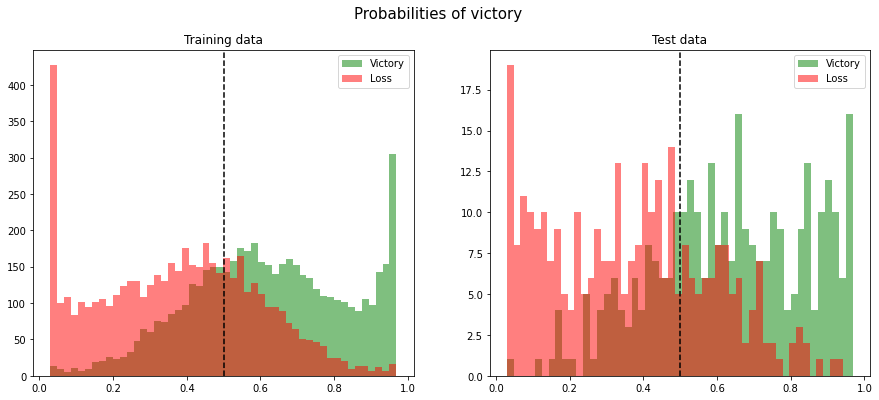

In [44]:
yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred, points=True)

In [40]:
pipe = Pipeline([('scl', tml.DfScaler()),
                 #('PCA', tml.DfPCA(n_components=0.9, compress=True, random_state=24)),
                 ('lgb', lgb.LGBMClassifier(learning_rate=0.1, n_estimators=500, num_leaves=150, max_depth=5,
                                           n_jobs=5, subsample=0.7, reg_alpha=1, reg_lambda=1))])

grid_param = {'scl__method': ['standard', 'robust'], 
               'PCA__n_components': [0.5, 0.6, 0.7, 0.8, 0.9], 
               'lgb__num_leaves': [10, 40, 70, 100], 
              'lgb__reg_alpha': [0, 0.5, 1, 2, 5], 
              'lgb__reg_lambda': [0, 0.5, 1, 2, 5]}

fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(df[to_use], pipe, kfolds, 'target', tune=False, 
                                                                                   param_grid=grid_param, predict_proba=True)

2015


Accuracy train: 		 0.684
Accuracy test: 			 0.7857
AUC ROC train: 			 0.684
AUC ROC test: 			 0.7857
Logloss train: 			 0.6585
Logloss test: 			 0.5001
Unsure train: 			 11.2103%
Unsure test: 			 11.1111%


________________________________________


2016


Accuracy train: 		 0.6944
Accuracy test: 			 0.6825
AUC ROC train: 			 0.6944
AUC ROC test: 			 0.6825
Logloss train: 			 0.6417
Logloss test: 			 0.7175
Unsure train: 			 11.1607%
Unsure test: 			 10.3175%


________________________________________


2017


Accuracy train: 		 0.6925
Accuracy test: 			 0.7143
AUC ROC train: 			 0.6925
AUC ROC test: 			 0.7143
Logloss train: 			 0.6601
Logloss test: 			 0.6461
Unsure train: 			 11.2103%
Unsure test: 			 9.5238%


________________________________________


2018


Accuracy train: 		 0.6935
Accuracy test: 			 0.7698
AUC ROC train: 			 0.6935
AUC ROC test: 			 0.7698
Logloss train: 			 0.6396
Logloss test: 			 0.6244
Unsure train: 			 12.4504%
Unsure test: 			 7.9365%


___________

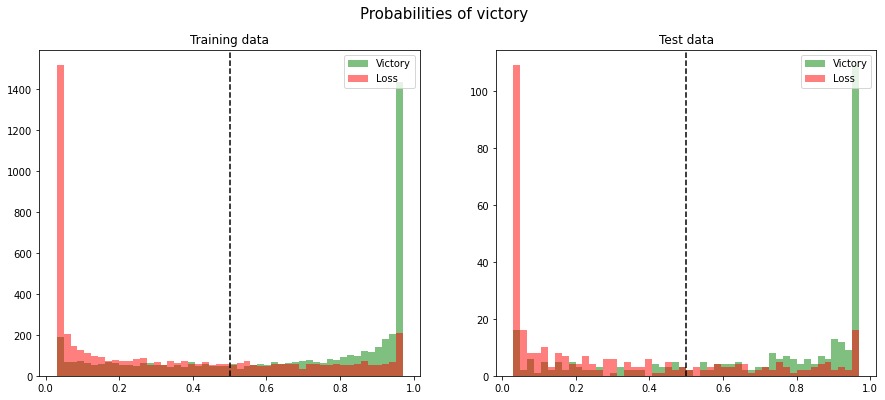

In [41]:
yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred, points=False)

In [42]:
imp_coef['2019'].head(20)

,mean,std
feat,,
T2_def_rating,270.571429,13.270387
T1_def_rating,268.000000,11.234866
T2_Blk,257.714286,8.322374
T1_DR,256.857143,10.191032
T1_Blk,256.000000,11.669047
T1_FGM_perc,246.142857,12.757195
T2_DR,239.000000,8.343327
T2_Stl,234.000000,13.603513
T2_Ast,230.571429,10.197650
